In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

x, y = make_moons(n_samples=500, noise=0.3, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [2]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# 硬投票
log_clf = LogisticRegression(solver='liblinear', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma='auto', random_state=42)

votingz_clf = VotingClassifier(
    estimators=[('lr',log_clf), ('rf',rnd_clf), ('svc',svm_clf)],
    voting='hard'
)

In [3]:
votingz_clf.fit(x, y)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', Rando...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [4]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, votingz_clf):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))


LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


In [5]:
# 软投票
# 如果所有分类器都能够估算出类别的概率（即有predict_proba（） 方法） ， 
# 那么你可以将概率在所有单个分类器上平均， 然后让Scikit-Learn给出平均概率最高的类别作为预测
# 通常来说， 它比硬投票法的表现更优， 因为它给予那些高度自信的投票更高的权重。 
# 而所有你需要做的就是用voting="soft"代替voting="hard"， 并确保所有分类器都可以估算出概率
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(x_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', Rando...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


# Bagging ensembles

In [24]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500, #分类器数量
    max_samples=100, #每个评估器取的实例数
    bootstrap=False, #是否样本放回
    n_jobs=-1, #-1调用所有内核
    random_state=42
)
bag_clf.fit(x_train, y_train)
y_pred = bag_clf.predict(x_test)

In [25]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.912

In [26]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(x_train, y_train)

y_pred_tree = tree_clf.predict(x_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [27]:
from matplotlib.colors import ListedColormap
import numpy as np

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

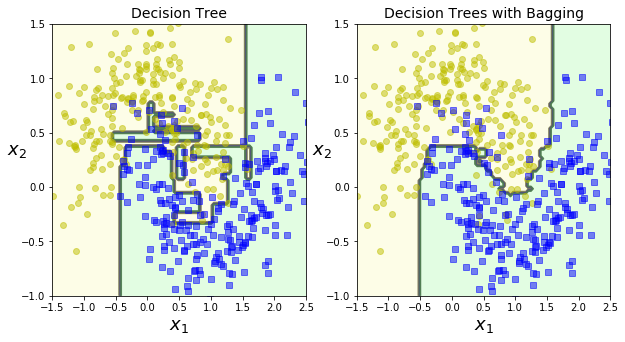

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.subplot(121)
plot_decision_boundary(tree_clf, x, y)
plt.title("Decision Tree", fontsize=14)

plt.subplot(122)
plot_decision_boundary(bag_clf, x, y)
plt.title("Decision Trees with Bagging", fontsize=14)

plt.show()

**外包评估 Out-of-Bag evaluation**


In [44]:
x_train.shape

(375, 2)

In [42]:
# bootstrap=True取样后放回样本，对于每个预测器而言，

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    bootstrap=True, #是否样本放回
    n_jobs=-1, #-1调用所有内核
    random_state=40,
    oob_score=True
)
bag_clf.fit(x_train, y_train)
bag_clf.oob_score_

0.9013333333333333

In [43]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.912

In [48]:
# 每个训练实例的包外决策函数也可以通过变量oob_decision_function_获得。 
# 本例中（基础预测器具备predict_proba（） 方法） ， 决策函数返回的是每个实例的类别概率。
bag_clf.oob_decision_function_
bag_clf.oob_decision_function_.shape,

((375, 2),)

**Random Patches和随机子空间**

*BaggingClassifier也支持对特征进行抽样， 这通过两个超参数控制： max_features和bootstrap_features。*

*它们的工作方式跟max_samples和bootstrap相同， 只是抽样对象不再是实例， 而是特征。*

*因此， 每个预测器将用输入特征的随机子集进行训练。这对于处理高维输入（例如图像） 特别有用。 
对训练实例和特征都进行抽样， 被称为Random Patches方法。*

*而保留所有训练实例（即bootstrap=False并且max_samples=1.0） 但是对特征进行抽样（即bootstrap_features=True并且/或max_features<1.0） ， 这被称为随机子空间法。 
对特征抽样给预测器带来更大的多样性， 所以以略高一点的偏差换取了更低的方差。*

**随机森林**

In [49]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42
)
bag_clf.fit(x_train, y_train)
y_pred = bag_clf.predict(x_test)

In [50]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, 
                                 max_leaf_nodes=16, 
                                 n_jobs=-1, 
                                 random_state=42)
rnd_clf.fit(x_train, y_train)

y_pred_rf = rnd_clf.predict(x_test)

In [53]:
np.sum(y_pred == y_pred_rf) / len(y_pred)

0.976